In [1]:
import os
import h5py
import imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib import rcParams
# Set font to Arial
rcParams['font.family'] = 'Arial'

from scipy.interpolate import griddata

import json

# from matplotlib import widgets
#Stackreg Regstrations
#https://pypi.org/project/pystackreg/
from pystackreg import StackReg

#Phase cross correlation
from skimage import data
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift
from scipy.ndimage import fourier_shift
from skimage.registration._phase_cross_correlation import _upsampled_dft

import scipy.ndimage as ndi
from scipy.ndimage import gaussian_filter1d

from ipywidgets import interact, widgets

from skimage import filters
from skimage import morphology
from skimage.segmentation import watershed

### Define helper functions

In [2]:
def overlayImages(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = np.stack(imgs, axis=0)

    return aggregator(imgs, axis=0)


def compositeImages(imgs, equalize=False, aggregator=np.mean):

    if equalize:
        imgs = [exposure.equalize_hist(img) for img in imgs]

    imgs = [img / img.max() for img in imgs]

    if len(imgs) < 3:
        imgs += [np.zeros(shape=imgs[0].shape)] * (3-len(imgs))

    imgs = np.dstack(imgs)

    return imgs

transformations = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}

def alignStackReg(image1, image2):
    
    sr = StackReg(StackReg.TRANSLATION)
    aligned_image2 = sr.register_transform(image1,image2)
    
    return image1,aligned_image2

def alignePhaseCrossCorr(image1,image2):
        
    vec, err, _ = phase_cross_correlation(image1, image2, upsample_factor=100)
   
    fft_image2 = np.fft.fftn(image2)
    shifted_fft_image2 = fourier_shift(fft_image2, vec)
    shifted_ifft_image2 = np.fft.ifftn(shifted_fft_image2)

    print(vec)
    return image1,shifted_ifft_image2.real

def alignPhaseCrossCorr_crop(image1,image2, x0, x1, y0, y1):
        
    vec, err, _ = phase_cross_correlation(image1[y0:y1,x0:x1], image2[y0:y1,x0:x1], upsample_factor=100)
   
    fft_image2 = np.fft.fftn(image2)
    shifted_fft_image2 = fourier_shift(fft_image2, vec)
    shifted_ifft_image2 = np.fft.ifftn(shifted_fft_image2)
    
    print(vec)
    return image1,shifted_ifft_image2.real

def imageSlider(image_array):
    
    num_image = len(image_array)
    
    def showImage(index):
        
        fig,ax = plt.subplots(nrows=1, ncols=1)
        image1 = ax.imshow(image_array[index], cmap='bone', vmin=-0.1,vmax=0.1)
        ax.set_title('Slice number: %d' % index)
        plt.colorbar(image1, ax=ax)
        plt.show()
        
    interact(showImage, index=widgets.IntSlider(min=0, max=num_image-1, step=1, value=0), continuous_update=True)
    
    
def maskegImage(image1, image2, scale):
    return image1*np.invert(image1<scale*np.amax(image2))

def grad(image,clip):

    grad_x = ndi.sobel(image, axis=1)
    grad_y = ndi.sobel(image, axis=0)

    grad_mag = np.sqrt(grad_x**2+grad_y**2)
    grad_mag=grad_mag/np.amax(grad_mag[clip:-clip,clip:-clip])
    return grad_mag

# def draw_group_as_background(ax, group, watershed_result, original_image):
#     "Draws a group from the watershed result as red background."
#     background_mask = (watershed_result == group)
#     cleaned = original_image * ~background_mask
#     ax.imshow(cleaned, cmap='gray')
#     ax.imshow(background_mask.reshape(background_mask.shape + (1,)) * np.array([1, 0, 0, 1]))

### Technical note

In [3]:
# skimage.registration.phase_cross_correlation(reference_image, moving_image, *, upsample_factor=1, space='real', disambiguate=False, reference_mask=None, moving_mask=None, overlap_ratio=0.3, normalization='phase')
#     upsample_factor: int, optional
#     Upsampling factor. Images will be registered to within 1 / upsample_factor of a pixel. 
#     For example upsample_factor == 20 means the images will be registered within 1/20th of a pixel. 
#     Default is 1 (no upsampling). Not used if any of reference_mask or moving_mask is not None.

# Load data

In [4]:
date = '2025-01-31'

# imageNumber_lcp = '055'
# imageNumber_rcp = '056'

# imageNumber_lcp = '057'
# imageNumber_rcp = '058'

imageNumber_lcp = '059'
imageNumber_rcp = '060'

entryNumber = 'entry1'

interpolation = 'linear' ## 'cubic'
detector = 'APD' ## available detectors 'APD', 'timemachine', 'PMT', 'VCO'
root_path = ''

# Check if image exists
image_path_lcp = (os.path.normpath(os.path.join(root_path, 'Sample_Image_'+date+'_'+imageNumber_lcp+'.hdf5')))
print(image_path_lcp)

if not os.path.exists(image_path_lcp):
    raise Exception("Image of LCP does not exist")


image_path_rcp = (os.path.normpath(os.path.join(root_path, 'Sample_Image_'+date+'_'+imageNumber_rcp+'.hdf5')))
print(image_path_rcp)

if not os.path.exists(image_path_rcp):
    raise Exception("Image of RCP does not exist")

C:\Users\yamamoto\Dropbox\MPI\Project\MnTe\Beamtime\BESSY_MAXYMUS_Jan2025\Data\Sample_Image_2025-01-31_059.hdf5
C:\Users\yamamoto\Dropbox\MPI\Project\MnTe\Beamtime\BESSY_MAXYMUS_Jan2025\Data\Sample_Image_2025-01-31_060.hdf5


In [5]:
# Loading and processing the LCP data / C+
datasetDet = '/'+entryNumber+'/'+detector
datasetInst = '/'+entryNumber+'/instrument'
datasetColl = '/'+entryNumber+'/collection'

with h5py.File(image_path_lcp,'r') as f:
    
    # Experimental conditions
    energy = np.array(f[datasetDet+'/energy'][0])
    magneticField = np.array(f[datasetColl+'/magnetic_field/value'][0])
    
    scanRequest = np.array(f[datasetColl+'/scan_request/scan_request'])
    scanRequeststr = scanRequest[0].decode("utf-8")
    scanRequestdecoded = json.loads(scanRequeststr)

    innerRegions = scanRequestdecoded['innerRegions']

#     for innerRegion in innerRegions:
#         axes = innerRegion.['axes']
#         for axis in axes:
#             n_points = axis['nPoints']
#             trajectories = axis['trajectories']
#             for trajectory in trajectories:
#                 positioner_name = trajectory['positionerName']
#                 if positioner_name == "FineY":
#                     centerY = trajectory['center']
#                     range_valueY = trajectory['range']
#                     stepY = trajectory['step']
# #                     print("FineY Trajectory Center:", centerY)
# #                     print("FineY Trajectory Range:", range_valueY)
# #                     print("FineY Trajectory Step:", stepY)
#                 elif positioner_name == "FineX":
#                     centerX = trajectory['center']
#                     range_valueX = trajectory['range']
#                     stepX = trajectory['step']
# #                     print("FineX Trajectory Center:", centerX)
# #                     print("FineX Trajectory Range:", range_valueX)
# #                     print("FineX Trajectory Step:", stepX)
    
    for innerRegion in innerRegions:
        axes = innerRegion.get('axes', [])
        for axis in axes:
            if 'nPoints' in axis:
                n_points = axis['nPoints']
                # Process n_points if needed
            trajectories = axis['trajectories']
            for trajectory in trajectories:
                positioner_name = trajectory['positionerName']
                if positioner_name == "FineY":
                    if 'center' in trajectory:
                        centerY = trajectory['center']
                        range_valueY = trajectory['range']
                        stepY = trajectory['step']
                        # print("FineY Trajectory Center:", centerY)
                elif positioner_name == "FineX":
                    if 'center' in trajectory:
                        centerX = trajectory['center']
                        range_valueX = trajectory['range']
                        stepX = trajectory['step']
                        print("FineX Trajectory Center:", centerX)

    print("Energy (eV):", energy)
    print("Magnetic field (mT):", magneticField)
    # print(scanRequest)
    print("Center positions (um):", centerX, ',', centerY)
    print("Range (um):",range_valueX, ',', range_valueY)
    print("Step (um):",stepX, ',', stepY)
    
    # Data
    I_lcp = f[datasetDet+'/data'][()]
    
    setpx = f[datasetDet+'/sample_x'][()]
    setpy = f[datasetDet+'/sample_y'][()]
    readx = f[datasetInst+'/sample_x/data'][()]
    ready = f[datasetInst+'/sample_y/data'][()]
    data = f[datasetInst+'/'+detector+'/data'][()]
      
    X,Y = np.meshgrid(setpx, setpy)
    
    Xq = readx-np.mean(readx)
    Yq = ready-np.mean(ready)
    X = X-np.mean(X)
    Y = Y-np.mean(Y)
    
    Ipc_lcp = griddata((Xq, Yq), data, (X, Y), method=interpolation, fill_value=0)


I_lcp = np.flip(I_lcp,0)
Ipc_lcp = np.flip(Ipc_lcp,0)

FineX Trajectory Center: 388.8011155268169
Energy (eV): 640.55
Magnetic field (mT): 0.0
Center positions (um): 388.8011155268169 , -1091.262147906539
Range (um): 12.0 , 17.5
Step (um): 0.05 , 0.05


Text(0.5, 0.98, 'LCP Scan number: 059')

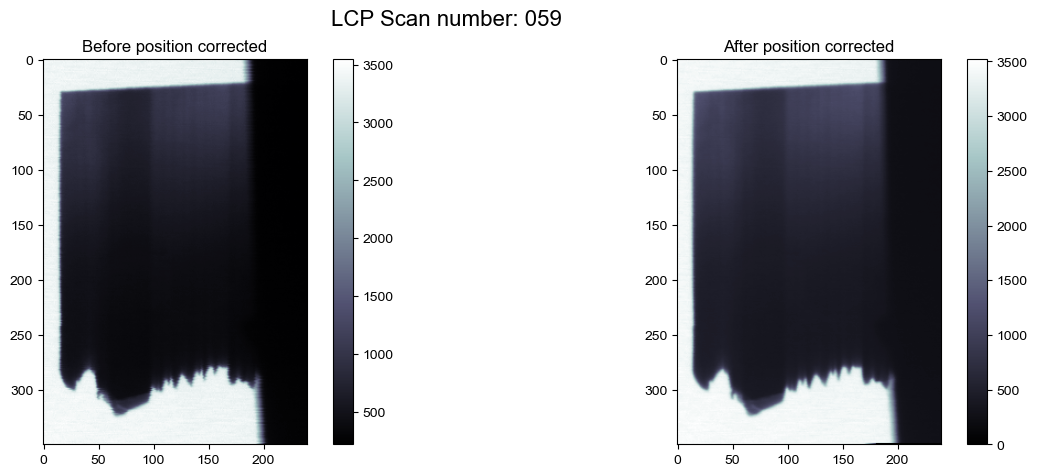

In [6]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#
im1=ax1.imshow(I_lcp, cmap='bone')#, vmin=0)#,vmax=0.1)
ax1.set_title('Before position corrected')
plt.colorbar(im1,ax=ax1)

#
im2=ax2.imshow(Ipc_lcp, cmap='bone')#, vmin=0)#,vmax=0.1)
ax2.set_title('After position corrected')
plt.colorbar(im2,ax=ax2)

fig.suptitle('LCP Scan number: '+imageNumber_lcp, fontsize=16)

In [7]:
# Loading and processing the RCP data / C-
datasetDet = '/'+entryNumber+'/'+detector
datasetInst = '/'+entryNumber+'/instrument'
datasetColl = '/'+entryNumber+'/collection'

with h5py.File(image_path_rcp,'r') as f:
    
    # Experimental conditions
    energy = np.array(f[datasetDet+'/energy'][0])
    magneticField = np.array(f[datasetColl+'/magnetic_field/value'][0])
    
    scanRequest = np.array(f[datasetColl+'/scan_request/scan_request'])
    scanRequeststr = scanRequest[0].decode("utf-8")
    scanRequestdecoded = json.loads(scanRequeststr)

    innerRegions = scanRequestdecoded['innerRegions']

#     for innerRegion in innerRegions:
#         axes = innerRegion['axes']
#         for axis in axes:
#             n_points = axis['nPoints']
#             trajectories = axis['trajectories']
#             for trajectory in trajectories:
#                 positioner_name = trajectory['positionerName']
#                 if positioner_name == "FineY":
#                     centerY = trajectory['center']
#                     range_valueY = trajectory['range']
#                     stepY = trajectory['step']
# #                     print("FineY Trajectory Center:", centerY)
# #                     print("FineY Trajectory Range:", range_valueY)
# #                     print("FineY Trajectory Step:", stepY)
#                 elif positioner_name == "FineX":
#                     centerX = trajectory['center']
#                     range_valueX = trajectory['range']
#                     stepX = trajectory['step']
# #                     print("FineX Trajectory Center:", centerX)
# #                     print("FineX Trajectory Range:", range_valueX)
# #                     print("FineX Trajectory Step:", stepX)

    for innerRegion in innerRegions:
        axes = innerRegion.get('axes', [])
        for axis in axes:
            if 'nPoints' in axis:
                n_points = axis['nPoints']
                # Process n_points if needed
            trajectories = axis['trajectories']
            for trajectory in trajectories:
                positioner_name = trajectory['positionerName']
                if positioner_name == "FineY":
                    if 'center' in trajectory:
                        centerY = trajectory['center']
                        range_valueY = trajectory['range']
                        stepY = trajectory['step']
                        # print("FineY Trajectory Center:", centerY)
                elif positioner_name == "FineX":
                    if 'center' in trajectory:
                        centerX = trajectory['center']
                        range_valueX = trajectory['range']
                        stepX = trajectory['step']
                        print("FineX Trajectory Center:", centerX)

    print("Energy (eV):", energy)
    print("Magnetic field (mT):", magneticField)
    # print(scanRequest)
    print("Center positions (um):", centerX, ',', centerY)
    print("Range (um):",range_valueX, ',', range_valueY)
    print("Step (um):",stepX, ',', stepY)
    
    # Data
    I_rcp = f[datasetDet+'/data'][()]
    
    setpx = f[datasetDet+'/sample_x'][()]
    setpy = f[datasetDet+'/sample_y'][()]
    readx = f[datasetInst+'/sample_x/data'][()]
    ready = f[datasetInst+'/sample_y/data'][()]
    data = f[datasetInst+'/'+detector+'/data'][()]
    
    X,Y = np.meshgrid(setpx, setpy)
    
    Xq = readx-np.mean(readx)
    Yq = ready-np.mean(ready)
    X = X-np.mean(X)
    Y = Y-np.mean(Y)
    
    Ipc_rcp = griddata((Xq, Yq), data, (X, Y), method=interpolation, fill_value=0)


I_rcp = np.flip(I_rcp,0)
Ipc_rcp = np.flip(Ipc_rcp,0)

FineX Trajectory Center: 388.8011155268169
Energy (eV): 640.55
Magnetic field (mT): 0.0
Center positions (um): 388.8011155268169 , -1091.262147906539
Range (um): 12.0 , 17.5
Step (um): 0.05 , 0.05


Text(0.5, 0.98, 'RCP Scan number: 060')

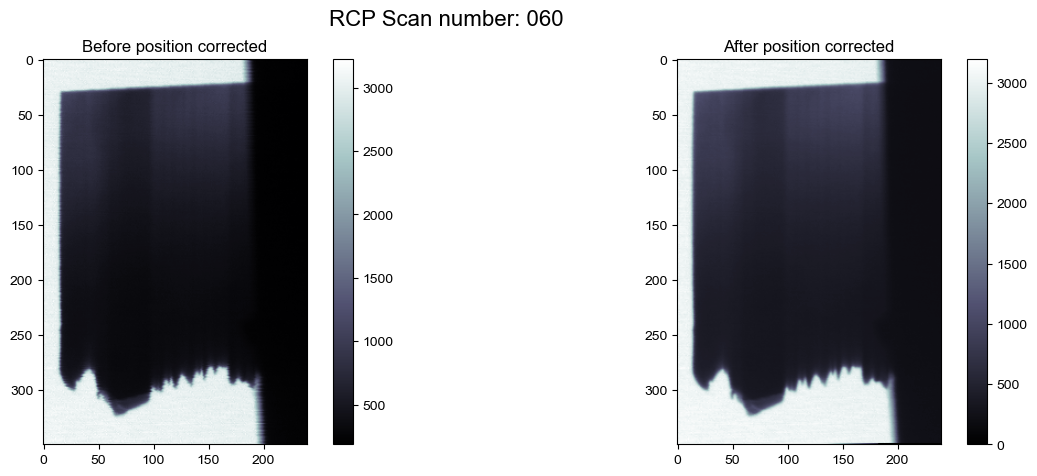

In [8]:
fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#
im1=ax1.imshow(I_rcp, cmap='bone')#, vmin=0)#,vmax=0.1)
ax1.set_title('Before position corrected')
plt.colorbar(im1,ax=ax1)

#
im2=ax2.imshow(Ipc_rcp, cmap='bone')#, vmin=0)#,vmax=0.1)
ax2.set_title('After position corrected')
plt.colorbar(im2,ax=ax2)

fig.suptitle('RCP Scan number: '+imageNumber_rcp, fontsize=16)

# Pre-alignment using Stackreg

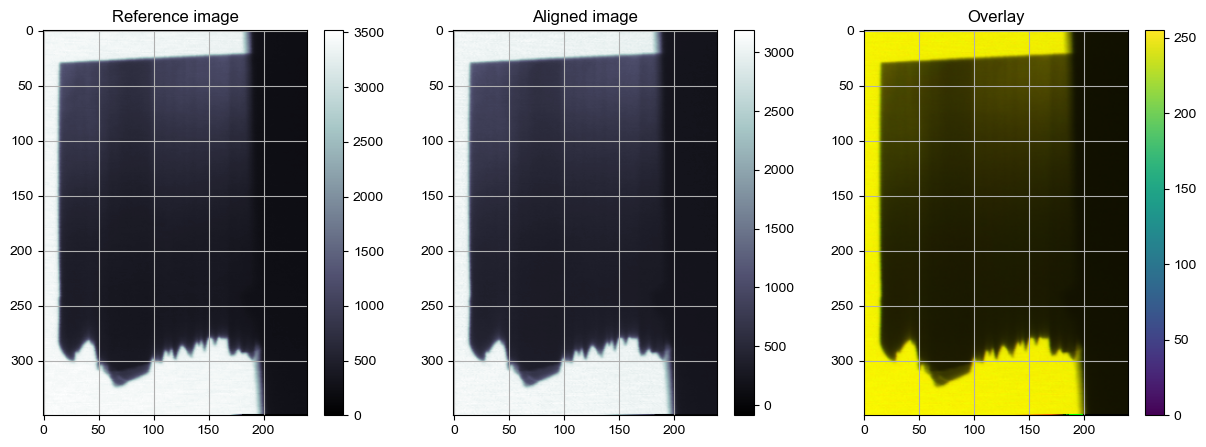

In [9]:
ref_image = Ipc_lcp
base_image = Ipc_rcp

_, pre_aligned_image = alignStackReg(ref_image, base_image)
pre_aligned_Ipc_rcp = pre_aligned_image

# afterReg = compositeImages([ref_image, pre_aligned_image])
afterReg = compositeImages([ref_image, pre_aligned_Ipc_rcp])
# afterReg = compositeImages([ref_image, base_image])

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

#
im1=ax1.imshow(ref_image, cmap='bone')#, vmin=0,vmax=1)
ax1.set_title('Reference image')
plt.colorbar(im1,ax=ax1)
ax1.grid()
#
# im2=ax2.imshow(pre_aligned_image, cmap='bone')#, vmin=0,vmax=1)
im2=ax2.imshow(pre_aligned_Ipc_rcp, cmap='bone')#, vmin=0,vmax=1)
ax2.set_title('Aligned image')
plt.colorbar(im2,ax=ax2)
ax2.grid()
#
im3=ax3.imshow((afterReg*255).astype(np.uint8))#, vmin=-1,vmax=1)
ax3.set_title('Overlay')
plt.colorbar(im3,ax=ax3)
ax3.grid()

# Crop image

In [11]:
# Cut the empty region
edge_x0 = 2
edge_x1 = 248
edge_y0 = 2
edge_y1 = 348

image_lcp = Ipc_lcp[edge_y0:edge_y1,edge_x0:edge_x1]
image_rcp = pre_aligned_Ipc_rcp[edge_y0:edge_y1,edge_x0:edge_x1]

print("Min value in image_lcp:", np.min(image_lcp))
print("Min value in image_rcp:", np.min(image_rcp))

Min value in image_lcp: 220.54598064045277
Min value in image_rcp: 191.89476013183594


In [12]:
amax = 0.472

# Alignment using Stackreg

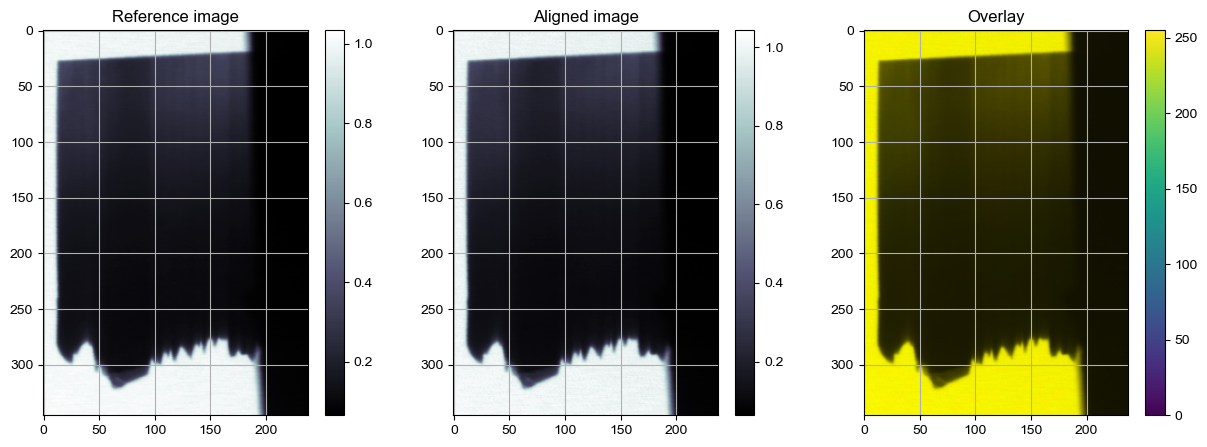

In [18]:
ref_image = norm_image_lcp
base_image = norm_image_rcp

_, aligned_image = alignStackReg(ref_image, base_image)
aligned_norm_image_rcp = aligned_image

afterReg = compositeImages([ref_image, aligned_image])

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

#
im1=ax1.imshow(ref_image, cmap='bone')#, vmin=0,vmax=1)
ax1.set_title('Reference image')
plt.colorbar(im1,ax=ax1)
ax1.grid()
#
im2=ax2.imshow(aligned_image, cmap='bone')#, vmin=0,vmax=1)
ax2.set_title('Aligned image')
plt.colorbar(im2,ax=ax2)
ax2.grid()
#
im3=ax3.imshow((afterReg*255).astype(np.uint8))#, vmin=-1,vmax=1)
ax3.set_title('Overlay')
plt.colorbar(im3,ax=ax3)
ax3.grid()

In [19]:
# ref_image = norm_dimage_lcp
# base_image = norm_dimage_rcp

# _, aligned_image = alignStackReg(ref_image, base_image)
# aligned_norm_dimage_rcp = aligned_image

# afterReg = compositeImages([ref_image, aligned_image])

# fig,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# #
# im1=ax1.imshow(ref_image, cmap='bone')#, vmin=0,vmax=1)
# ax1.set_title('Reference image')
# plt.colorbar(im1,ax=ax1)
# ax1.grid()
# #
# im2=ax2.imshow(aligned_image, cmap='bone')#, vmin=0,vmax=1)
# ax2.set_title('Aligned image')
# plt.colorbar(im2,ax=ax2)
# ax2.grid()
# #
# im3=ax3.imshow((afterReg*255).astype(np.uint8))#, vmin=-1,vmax=1)
# ax3.set_title('Overlay')
# plt.colorbar(im3,ax=ax3)
# ax3.grid()

# Alignment using Phase Cross Correlation

In [20]:
# ref_image = norm_image_lcp
# base_image = norm_image_rcp

# vec, err, _ = phase_cross_correlation(ref_image, base_image, upsample_factor=100)

# print(vec)

# fft_image = np.fft.fftn(base_image)
# shifted_fft_image = fourier_shift(fft_image, vec)
# shifted_ifft_image = np.fft.ifftn(shifted_fft_image)

# aligned_norm_image_rcp = shifted_ifft_image.real


# afterReg = compositeImages([ref_image, aligned_norm_image_rcp])

# fig,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# #
# im1=ax1.imshow(ref_image, cmap='bone')#, vmin=0,vmax=1)
# ax1.set_title('Reference image')
# plt.colorbar(im1,ax=ax1)
# ax1.grid()
# #
# im2=ax2.imshow(aligned_image, cmap='bone')#, vmin=0,vmax=1)
# ax2.set_title('Aligned image')
# plt.colorbar(im2,ax=ax2)
# ax2.grid()
# #
# im3=ax3.imshow((afterReg*255).astype(np.uint8))#, vmin=-1,vmax=1)
# ax3.set_title('Overlay')
# plt.colorbar(im3,ax=ax3)
# ax3.grid()

[ 0.01 -0.38]


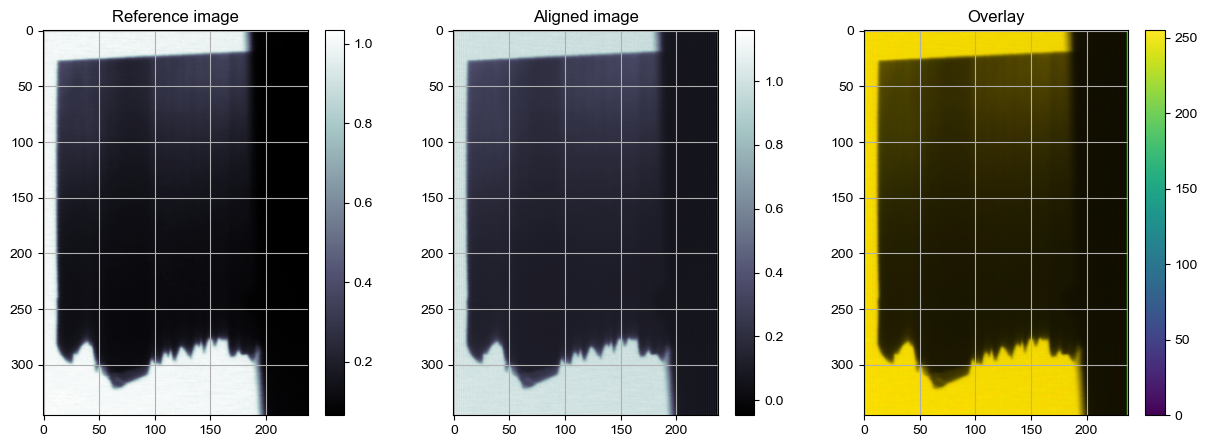

In [21]:
ref_image = norm_dimage_lcp
base_image = norm_dimage_rcp

vec, err, _ = phase_cross_correlation(ref_image, base_image, upsample_factor=100)

print(vec)

fft_image = np.fft.fftn(base_image)
shifted_fft_image = fourier_shift(fft_image, vec)
shifted_ifft_image = np.fft.ifftn(shifted_fft_image)

aligned_norm_dimage_rcp = shifted_ifft_image.real


afterReg = compositeImages([ref_image, aligned_norm_dimage_rcp])

fig,(ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

#
im1=ax1.imshow(ref_image, cmap='bone')#, vmin=0,vmax=1)
ax1.set_title('Reference image')
plt.colorbar(im1,ax=ax1)
ax1.grid()
#
im2=ax2.imshow(aligned_norm_dimage_rcp, cmap='bone')#, vmin=0,vmax=1)
ax2.set_title('Aligned image')
plt.colorbar(im2,ax=ax2)
ax2.grid()
#
im3=ax3.imshow((afterReg*255).astype(np.uint8))#, vmin=-1,vmax=1)
ax3.set_title('Overlay')
plt.colorbar(im3,ax=ax3)
ax3.grid()

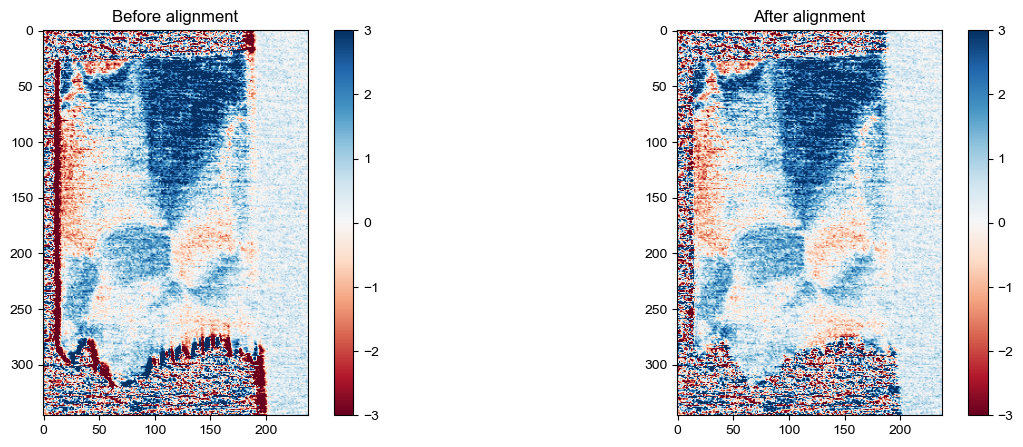

In [22]:
# aligned_image_xmcd = 100 * (norm_image_lcp - aligned_norm_image_rcp)#/ (norm_image_lcp + aligned_norm_image_rcp)
aligned_image_xmcd = 100 * (norm_image_lcp - aligned_norm_image_rcp) / amax
aligned_image_ele = (norm_image_lcp + aligned_norm_image_rcp) / 2

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#
im1=ax1.imshow(image_xmcd, cmap='RdBu', vmin=-3,vmax=3)
ax1.set_title('Before alignment')
plt.colorbar(im1,ax=ax1)
# ax1.grid()
#
im2=ax2.imshow(aligned_image_xmcd, cmap='RdBu', vmin=-3,vmax=3)
ax2.set_title('After alignment')
plt.colorbar(im2,ax=ax2)
# ax1.grid()

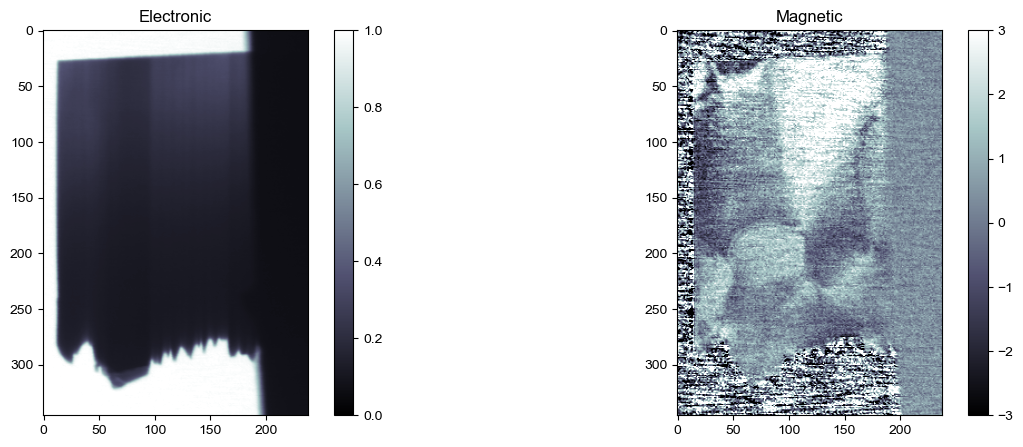

In [29]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#
im1=ax1.imshow(aligned_image_ele, cmap='bone', vmin=0,vmax=1)
ax1.set_title('Electronic')
plt.colorbar(im1,ax=ax1)
# ax1.grid()
#
im2=ax2.imshow(aligned_image_xmcd, cmap='bone', vmin=-3,vmax=3)
ax2.set_title('Magnetic')
plt.colorbar(im2,ax=ax2)
# ax2.grid()

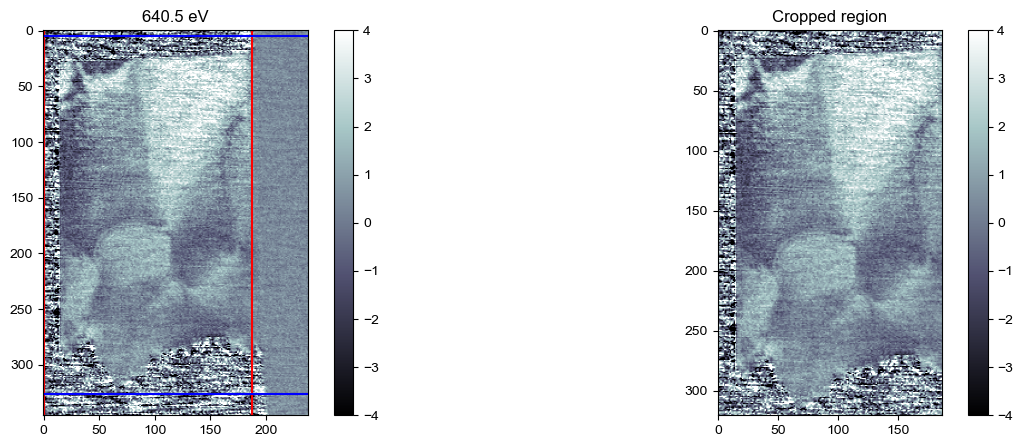

In [31]:
# Set ROI for normalization
image =aligned_image_xmcd
# image =aligned_dark_image_xmcd

crop_x0 = 0
crop_x1 = 187
crop_y0 = 5
crop_y1 = 326

fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

#
im1=ax1.imshow(image, cmap='bone', vmin=-4, vmax=4)
ax1.set_title('%.1f eV' % (energy))
plt.colorbar(im1,ax=ax1)
ax1.axvline(crop_x0,color='r')
ax1.axvline(crop_x1,color='r')
ax1.axhline(crop_y0,color='b')
ax1.axhline(crop_y1,color='b')

#
im2=ax2.imshow(image[crop_y0:crop_y1,crop_x0:crop_x1], cmap='bone', vmin=-4, vmax=4)
ax2.set_title('Cropped region')
plt.colorbar(im2,ax=ax2)

In [32]:
cropped_norm_image_lcp = norm_image_lcp[crop_y0:crop_y1, crop_x0:crop_x1]
cropped_norm_image_rcp = norm_image_rcp[crop_y0:crop_y1, crop_x0:crop_x1]

cropped_aligned_image_xmcd = aligned_image_xmcd[crop_y0:crop_y1, crop_x0:crop_x1]

cropped_aligned_image_ele = aligned_image_ele[crop_y0:crop_y1, crop_x0:crop_x1]

# Save images

In [61]:
# save_path = ''
save_path = ''
print(save_path)

C:/Users/yamamoto/Dropbox/MPI/Project/MnTe/Beamtime/BESSY_MAXYMUS_Jan2025/Analyzed/XMCD/Overview/Cropped/


In [62]:
length = 2 # um
scalebar_length = length / stepX
print(stepX)
scalebar_color = 'black'

0.05


In [63]:
# base_image = cropped_aligned_image_ele
# fname = 'cropped_aligned_image_ele_%.2feV_%s_%s' %(energy, imageNumber_lcp, imageNumber_rcp)

base_image = cropped_aligned_image_xmcd
fname = 'cropped_aligned_image_xmcd_%.2feV_%s_%s' %(energy, imageNumber_lcp, imageNumber_rcp)

# base_image = cropped_aligned_dark_image_xmcd
# fname = 'cropped_aligned_dark_image_xmcd_%.2feV_%s_%s' %(energy, imageNumber_lcp, imageNumber_rcp)

# base_image = cropped_norm_image_lcp
# fname = 'cropped_norm_image_lcp_%.2feV_%s' %(energy, imageNumber_lcp)#, imageNumber_rcp)

# base_image = cropped_norm_image_rcp
# fname = 'cropped_norm_image_rcp_%.2feV_%s' %(energy, imageNumber_rcp)#, imageNumber_rcp)

# base_image = rm_image_xmcd

print(fname)

image = base_image

# blur = filters.gaussian(base_image, sigma=1)
# image = blur

cropped_aligned_image_xmcd_640.55eV_059_060


C:/Users/yamamoto/Dropbox/MPI/Project/MnTe/Beamtime/BESSY_MAXYMUS_Jan2025/Analyzed/XMCD/Overview/Cropped/cropped_aligned_image_xmcd_640.55eV_059_060_w_scalebar.png


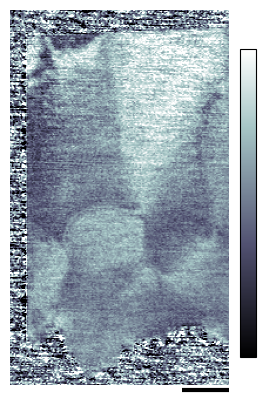

In [64]:
fig,(ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

#
im1=ax1.imshow(image, cmap='bone', vmin=-4, vmax=4)
# im1=ax1.imshow(image, cmap='bone', vmin=0, vmax=1)
# ax1.set_title('XMCD')
# plt.colorbar(im1,ax=ax1, pad=0.01)
plt.colorbar(im1,ax=ax1, pad=0.01, shrink=0.8, ticks=[-100, -50])

# Adjust axis limits to make room for the scale bar
ax1.set_ylim(image.shape[0]+8, 0)  # Expand bottom margin (negative values extend below)
ax1.set_xlim(0, image.shape[1])

# Add scale bar using axhline
# scale_bar_y = 355  # Vertical position (outside the image in data coordinates)
scale_bar_y = 325  # Vertical position (outside the image in data coordinates)
scale_bar_x_start = image.shape[1] - scalebar_length  # Start position (in data coordinates)
scale_bar_x_end = image.shape[1]  # End position (length of the scale bar)

ax1.hlines(
    y=scale_bar_y,  # Vertical position of the line
    xmin=scale_bar_x_start,  # Start of the scale bar
    xmax=scale_bar_x_end,  # End of the scale bar
    colors=scalebar_color,
    linewidth=3,
    )

ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')

image_png = save_path + fname + '_'+ 'w_scalebar' + '.png'
# image_png = save_path + fname + '.png'
print(image_png)
plt.savefig(image_png, dpi=300, bbox_inches='tight', pad_inches=0)
# plt.close()  # Close the figure to free up memory

image_npy = save_path + fname + '_'+ 'w_scalebar' + '.npy'
np.save(image_npy, image)
# np.save(image_npy, blur)

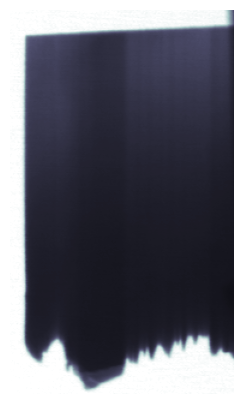

In [56]:
fig,(ax1) = plt.subplots(nrows=1, ncols=1, figsize=(15,5))

#
# im1=ax1.imshow(image, cmap='bone', vmin=-4, vmax=4)
im1=ax1.imshow(image, cmap='bone', vmin=0, vmax=1)
# ax1.set_title('XMCD')
# plt.colorbar(im1,ax=ax1, pad=0.02)

# Adjust axis limits to make room for the scale bar
ax1.set_ylim(image.shape[0], 0)  # Expand bottom margin (negative values extend below)
ax1.set_xlim(0, image.shape[1])

# # Add scale bar using axhline
# scale_bar_y = 355  # Vertical position (outside the image in data coordinates)
# scale_bar_x_start = image.shape[1] - scalebar_length  # Start position (in data coordinates)
# scale_bar_x_end = image.shape[1]  # End position (length of the scale bar)

# ax1.hlines(
#     y=scale_bar_y,  # Vertical position of the line
#     xmin=scale_bar_x_start,  # Start of the scale bar
#     xmax=scale_bar_x_end,  # End of the scale bar
#     colors=scalebar_color,
#     linewidth=3,
#     )

ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')

image_png = save_path + fname + '.png'
# print(image_png)
plt.savefig(image_png, dpi=300, bbox_inches='tight', pad_inches=0)
# plt.close()  # Close the figure to free up memory

image_npy = save_path + fname + '.npy'
np.save(image_npy, image)
# np.save(image_npy, blur)